In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


# DATA AND FUNCTIONS

In [11]:
# Load the dataset
data = pd.read_csv(r"revisedLoL_matchdata.csv")

# Drop an 'index' column that is there by my data collection mistake
data = data.drop(['index'],axis=1)

# Default red team Id = 200. Change the red team ID to 0 and blue to 1. 
data['winning_team'] = data['winning_team'].replace([200,100],[0,1])
data.head(5)

,game_id,winning_team,in_game_time,ally_top_level,ally_jgl_level,ally_mid_level,ally_bot_level,ally_sup_level,enemy_top_level,enemy_jgl_level,...,dragon_killed,dragon_lost,voidgrub_killed,voidgrub_lost,riftherald_killed,riftherald_lost,baron_killed,baron_lost,champion_killed,champion_death
0,7358388756,0.0,10.003517,7.0,7.0,7.0,8.0,5.0,8.0,6.0,...,0,1,0,1,0,0,0,0,1,2
1,7358388756,0.0,13.004633,9.0,8.0,8.0,9.0,7.0,9.0,9.0,...,0,1,0,3,0,1,0,0,1,7
2,7358388756,0.0,15.277683,10.0,9.0,9.0,10.0,7.0,11.0,10.0,...,0,1,0,6,0,1,0,0,5,17
3,7347700848,0.0,10.003133,8.0,7.0,9.0,7.0,5.0,7.0,7.0,...,0,0,0,3,0,0,0,0,2,2
4,7347700848,0.0,13.004267,11.0,8.0,10.0,8.0,6.0,8.0,8.0,...,0,1,0,3,1,0,0,0,3,4


In [12]:
# Feature and Response
X = data.drop(['game_id','winning_team'],axis=1)
Y = data['winning_team']

In [13]:
# Game stages dict
# Key is a time interval in the game, e.g [10,13). Up to [37,40) and everything else is 40+
game_stages = {f'[{i},{i+3})': data[(data['in_game_time'] >= i) & (data['in_game_time'] < i+3)] for i in range(10,40,3)}
game_stages['40+'] = data[data['in_game_time'] >= 40]

In [14]:
# Scaler object
scalerX = StandardScaler().fit(X)
# K-Fold object
k_folds = KFold(n_splits=5, shuffle = True, random_state = 123)

In [15]:
# Define a function to compute the ECE
def ECE_compute(y_prob, prob_true, prob_pred,num_bins=10):
    # y_prob: an array of probability belong to class 1
    # prob_true: an array of observed probability of a bin
    # prob_pred: an array of mean probability of a bin 
    ECE_score = 0
    for bin in range(num_bins):
        ECE_score += len(y_prob[(y_prob >= bin/num_bins) & (y_prob < (bin+1)/num_bins)]) * abs(prob_true[bin] - prob_pred[bin])
    return ECE_score/len(y_prob)

In [16]:
# Define a function that compute the null model accuracy 
# Null model := always predict the class that appear the most 
def Null_accuracy(y_true):
    null_accuracy = max(y_true.value_counts())/len(y_true)
    return null_accuracy

# LOGISTIC REGRESSION

In [17]:
# Perform cross-validation and get the prediction and associated probability
LR_y_pred = cross_val_predict(LogisticRegression(), scalerX.transform(X), Y, cv=k_folds, n_jobs = -1,method='predict')
LR_y_prob = cross_val_predict(LogisticRegression(), scalerX.transform(X), Y, cv=k_folds, n_jobs = -1,method='predict_proba')

### SCORE AND CONFUSION MATRIX

0.8487444360460233


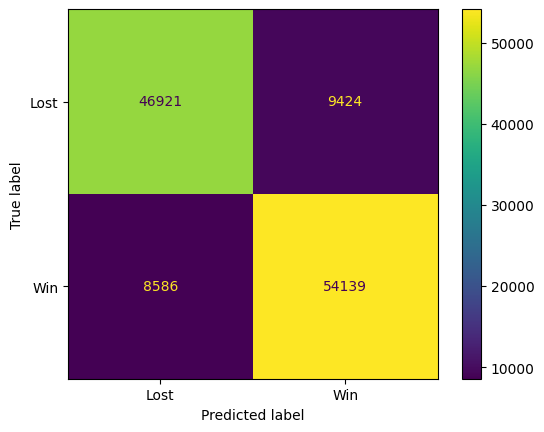

In [18]:
LR_accuracy = accuracy_score(Y,LR_y_pred)
print(LR_accuracy)
LR_cfm = confusion_matrix(Y,LR_y_pred)
ConfusionMatrixDisplay.from_predictions(Y, LR_y_pred,display_labels = ['Lost','Win'])

# RANDOM FOREST

In [19]:
RF_y_pred = cross_val_predict(RandomForestClassifier(), X, Y, cv=k_folds, n_jobs = -1,method='predict')
RF_y_prob = cross_val_predict(RandomForestClassifier(), X, Y, cv=k_folds, n_jobs = -1,method='predict_proba')

### SCORE AND CONFUSION MATRIX

0.8553623918703284


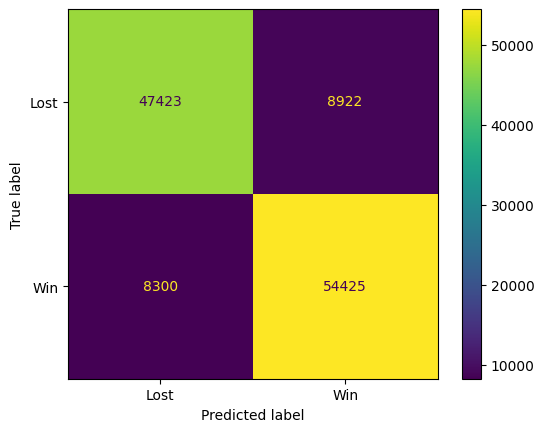

In [20]:
RF_accuracy = accuracy_score(Y,RF_y_pred)
print(RF_accuracy)
RF_cfm = confusion_matrix(Y,RF_y_pred)
ConfusionMatrixDisplay.from_predictions(Y, RF_y_pred, display_labels = ['Lost','Win'])

# SUPPORT VECTOR MACHINE (calibrated?)

In [21]:
# Fit
svc = CalibratedClassifierCV(LinearSVC(), cv = k_folds, n_jobs = -1)
svc.fit(scalerX.transform(X),Y)

CalibratedClassifierCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                       estimator=LinearSVC(), n_jobs=-1)

In [22]:
SVC_y_pred = svc.predict(scalerX.transform(X))
SVC_y_prob = svc.predict_proba(scalerX.transform(X))

### SCORE AND CONFUSION MATRIX

0.8499454102628706


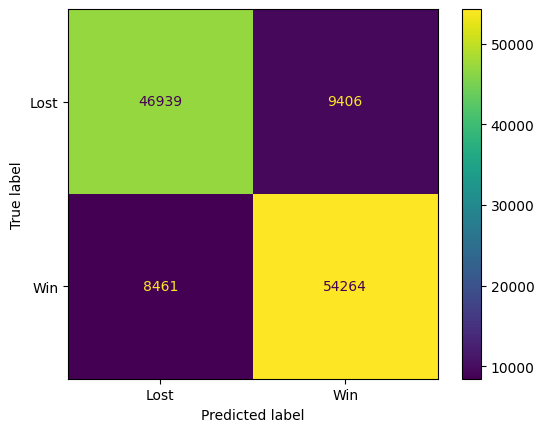

In [23]:
SVC_accuracy = accuracy_score(Y,SVC_y_pred)
print(SVC_accuracy)
SVC_cfm = confusion_matrix(Y,SVC_y_pred)
ConfusionMatrixDisplay.from_predictions(Y, SVC_y_pred, display_labels = ['Lost','Win'])

# ACCURACY OVER TIME

In [24]:
# Logistic regression model accuracy as game progress
LR_acc_time = np.array([accuracy_score(game_stages[time_interval]['winning_team'], 
                                       LR_y_pred[game_stages[time_interval].index] 
                                       ) for time_interval in game_stages])

# Random forest model accuracy as game progress
RF_acc_time = np.array([accuracy_score(game_stages[time_interval]['winning_team'], 
                                       RF_y_pred[game_stages[time_interval].index] 
                                       ) for time_interval in game_stages])

# Support vector machine model accuracy as game progress
SVC_acc_time = np.array([accuracy_score(game_stages[time_interval]['winning_team'], 
                                       SVC_y_pred[game_stages[time_interval].index] 
                                       ) for time_interval in game_stages])

# Null model accuracy as game progress
null_acc_time = np.array([Null_accuracy(game_stages[time_interval]['winning_team']) for time_interval in game_stages])

time = list(game_stages.keys())



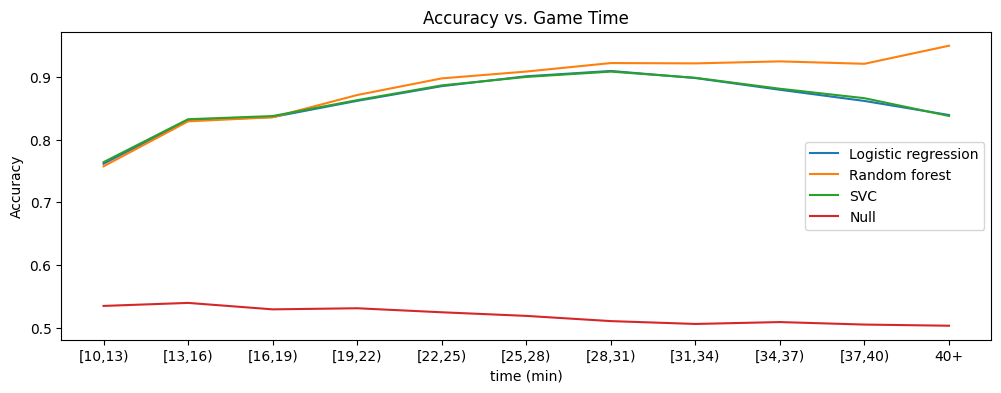

In [53]:
fig = plt.figure()
fig.set_size_inches(12,4)
plt.plot(time,LR_acc_time, label = 'Logistic regression')
plt.plot(time,RF_acc_time, label = 'Random forest')
plt.plot(time,SVC_acc_time, label = 'SVC')
plt.plot(time,null_acc_time, label = 'Null')
plt.xlabel('time (min)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Game Time')
plt.legend()
plt.show()

# CALIBRATION

In [26]:
# Making the perfect calibration line
x = np.linspace(0,1)
y = x

### RELIABILITY DIAGRAM AND ECE

#### Logistic Regression

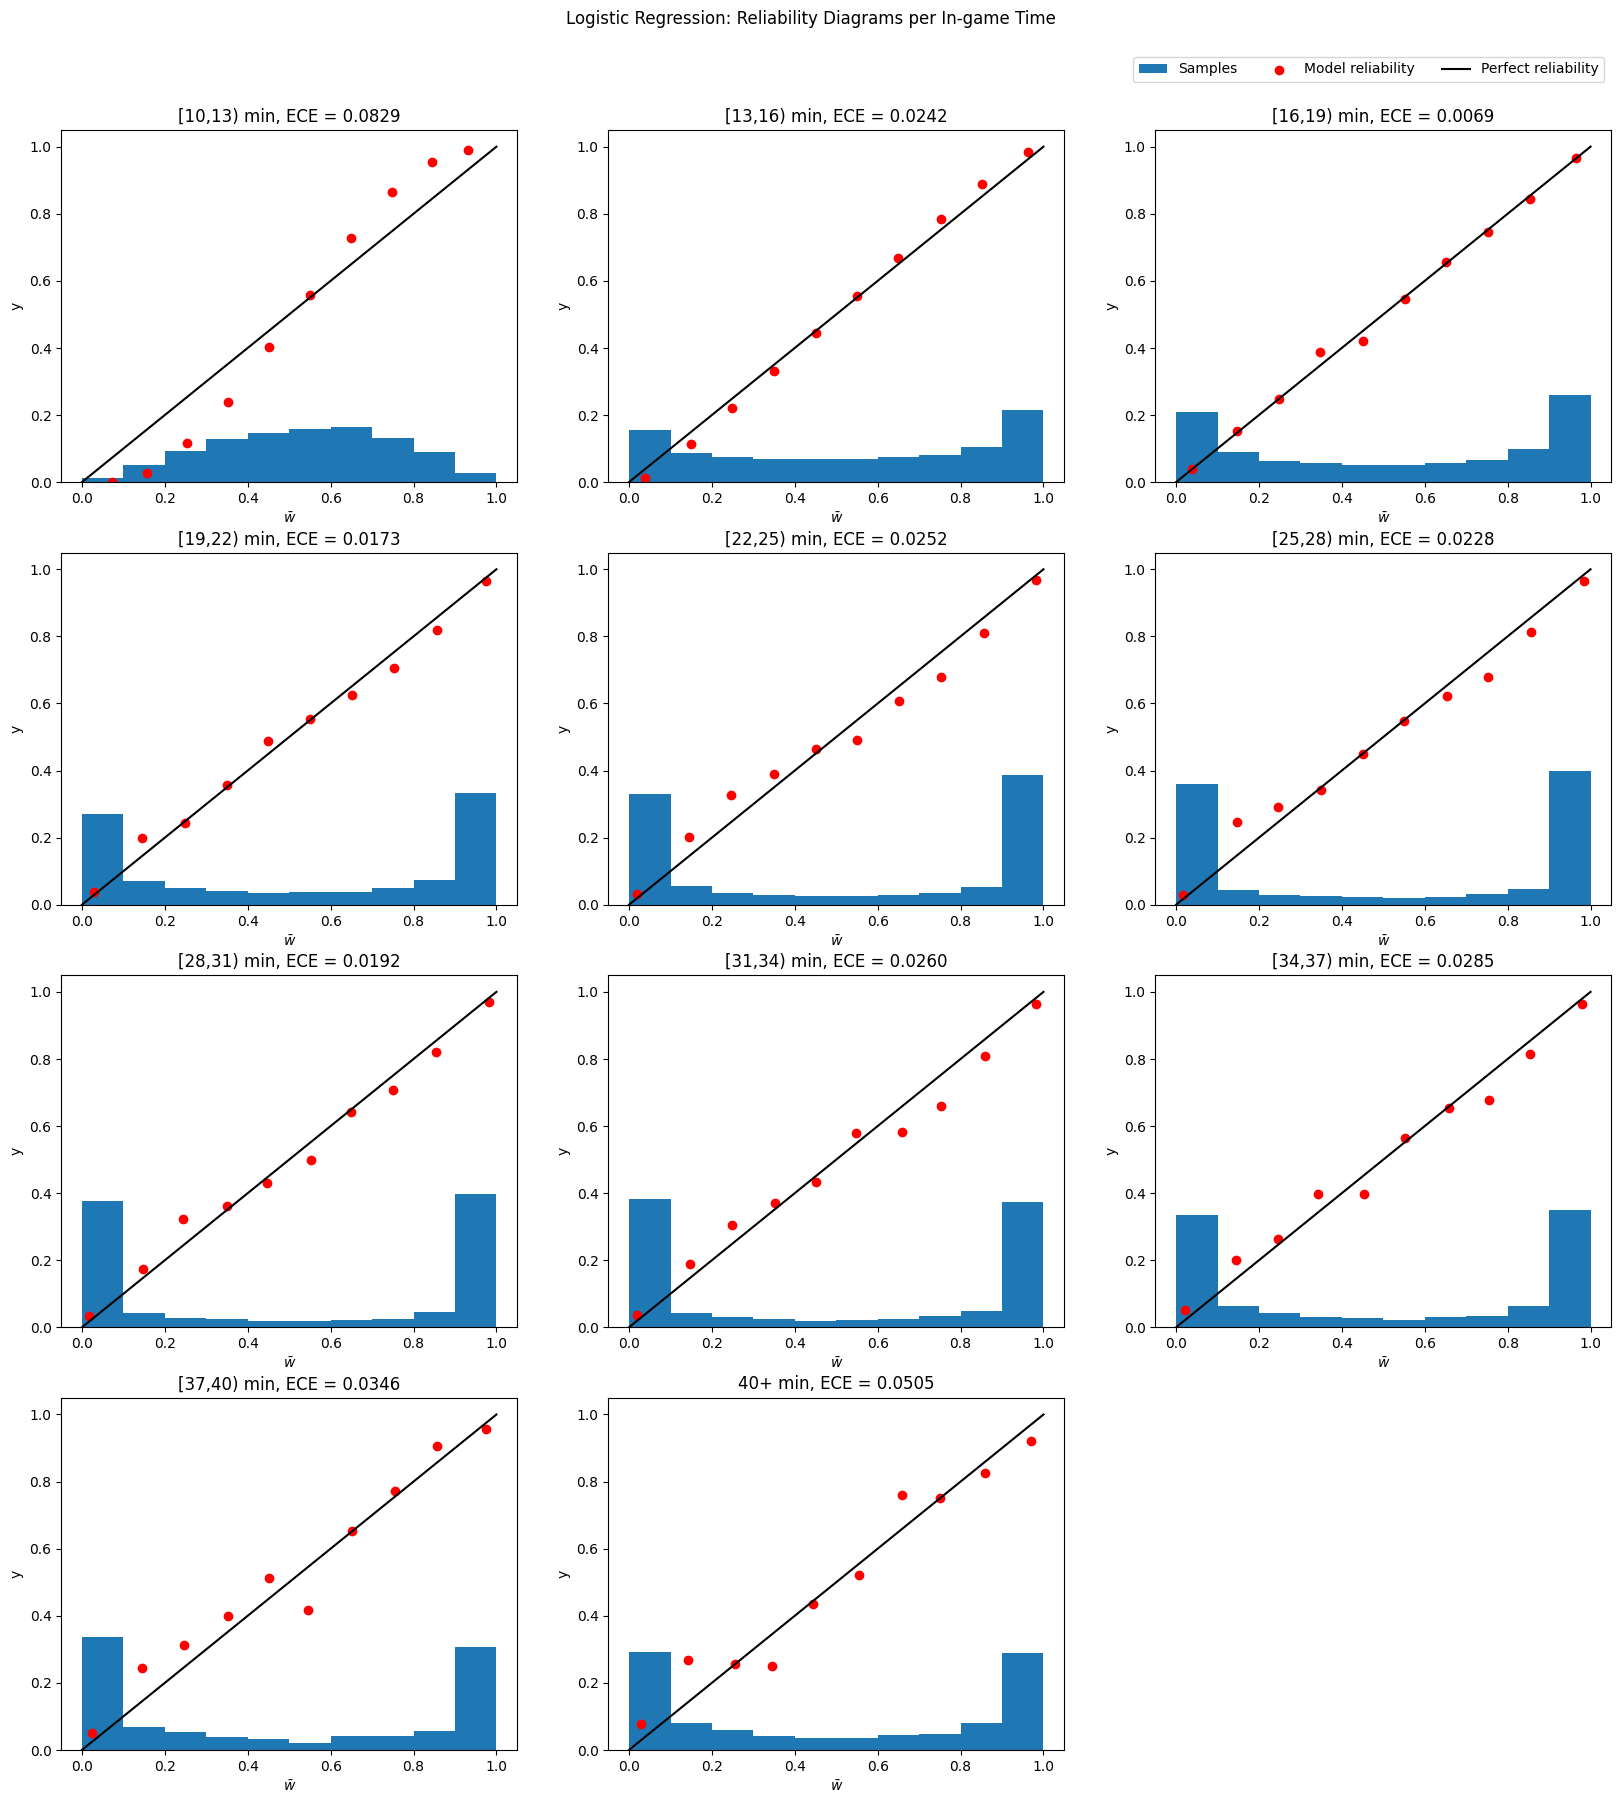

In [46]:
# Create a figure with 12 subplots
fig, ax = plt.subplots(4,3)

#Set appropriate size for figure
fig.set_size_inches(20, 20)


# ax panel indices
i,j = 0,0

for time_interval in game_stages:
    y_true = game_stages[time_interval]['winning_team']
    
    # Logistic regression predicted probability in time_interval
    LR_prob = LR_y_prob[game_stages[time_interval].index,1]

    # Mean of predicted probability and observed probability in 10 bins
    prob_true, prob_pred = calibration_curve(y_true,LR_prob,n_bins = 10)

    ECE_score = ECE_compute(LR_prob,prob_pred,prob_true)

    # Plotting
    count,bins = np.histogram(LR_prob,range=[0,1],bins=10)
    
    ax[i,j].hist(bins[:-1], bins, weights=count/np.sum(count),label='Samples')
    ax[i,j].scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
    ax[i,j].plot(x,y,color='black', label = 'Perfect reliability')
    ax[i,j].set_title(f'{time_interval} min, ECE = {ECE_score:.4f}')
    ax[i,j].set_xlabel(r'$\bar{w}$')
    ax[i,j].set_ylabel(r'y')
    
    if j < 2: 
        j += 1
    else:
        i += 1
        j = 0

lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=3,bbox_to_anchor=(0.90, 0.96))
fig.delaxes(ax[3,2])
fig.suptitle('Logistic Regression: Reliability Diagrams per In-game Time')
fig.subplots_adjust(top=0.92)
plt.savefig('LR_reliability')
plt.show()


In [42]:
prob_true, prob_pred = calibration_curve(Y,LR_y_prob[:,1],n_bins = 10)
LR_overall_ECE = ECE_compute(LR_y_prob,prob_true,prob_pred)
print(f'The ECE score of Logistic Regression is {LR_overall_ECE:.4f}')

The ECE score of Logistic Regression is 0.0255


#### RANDOM FOREST

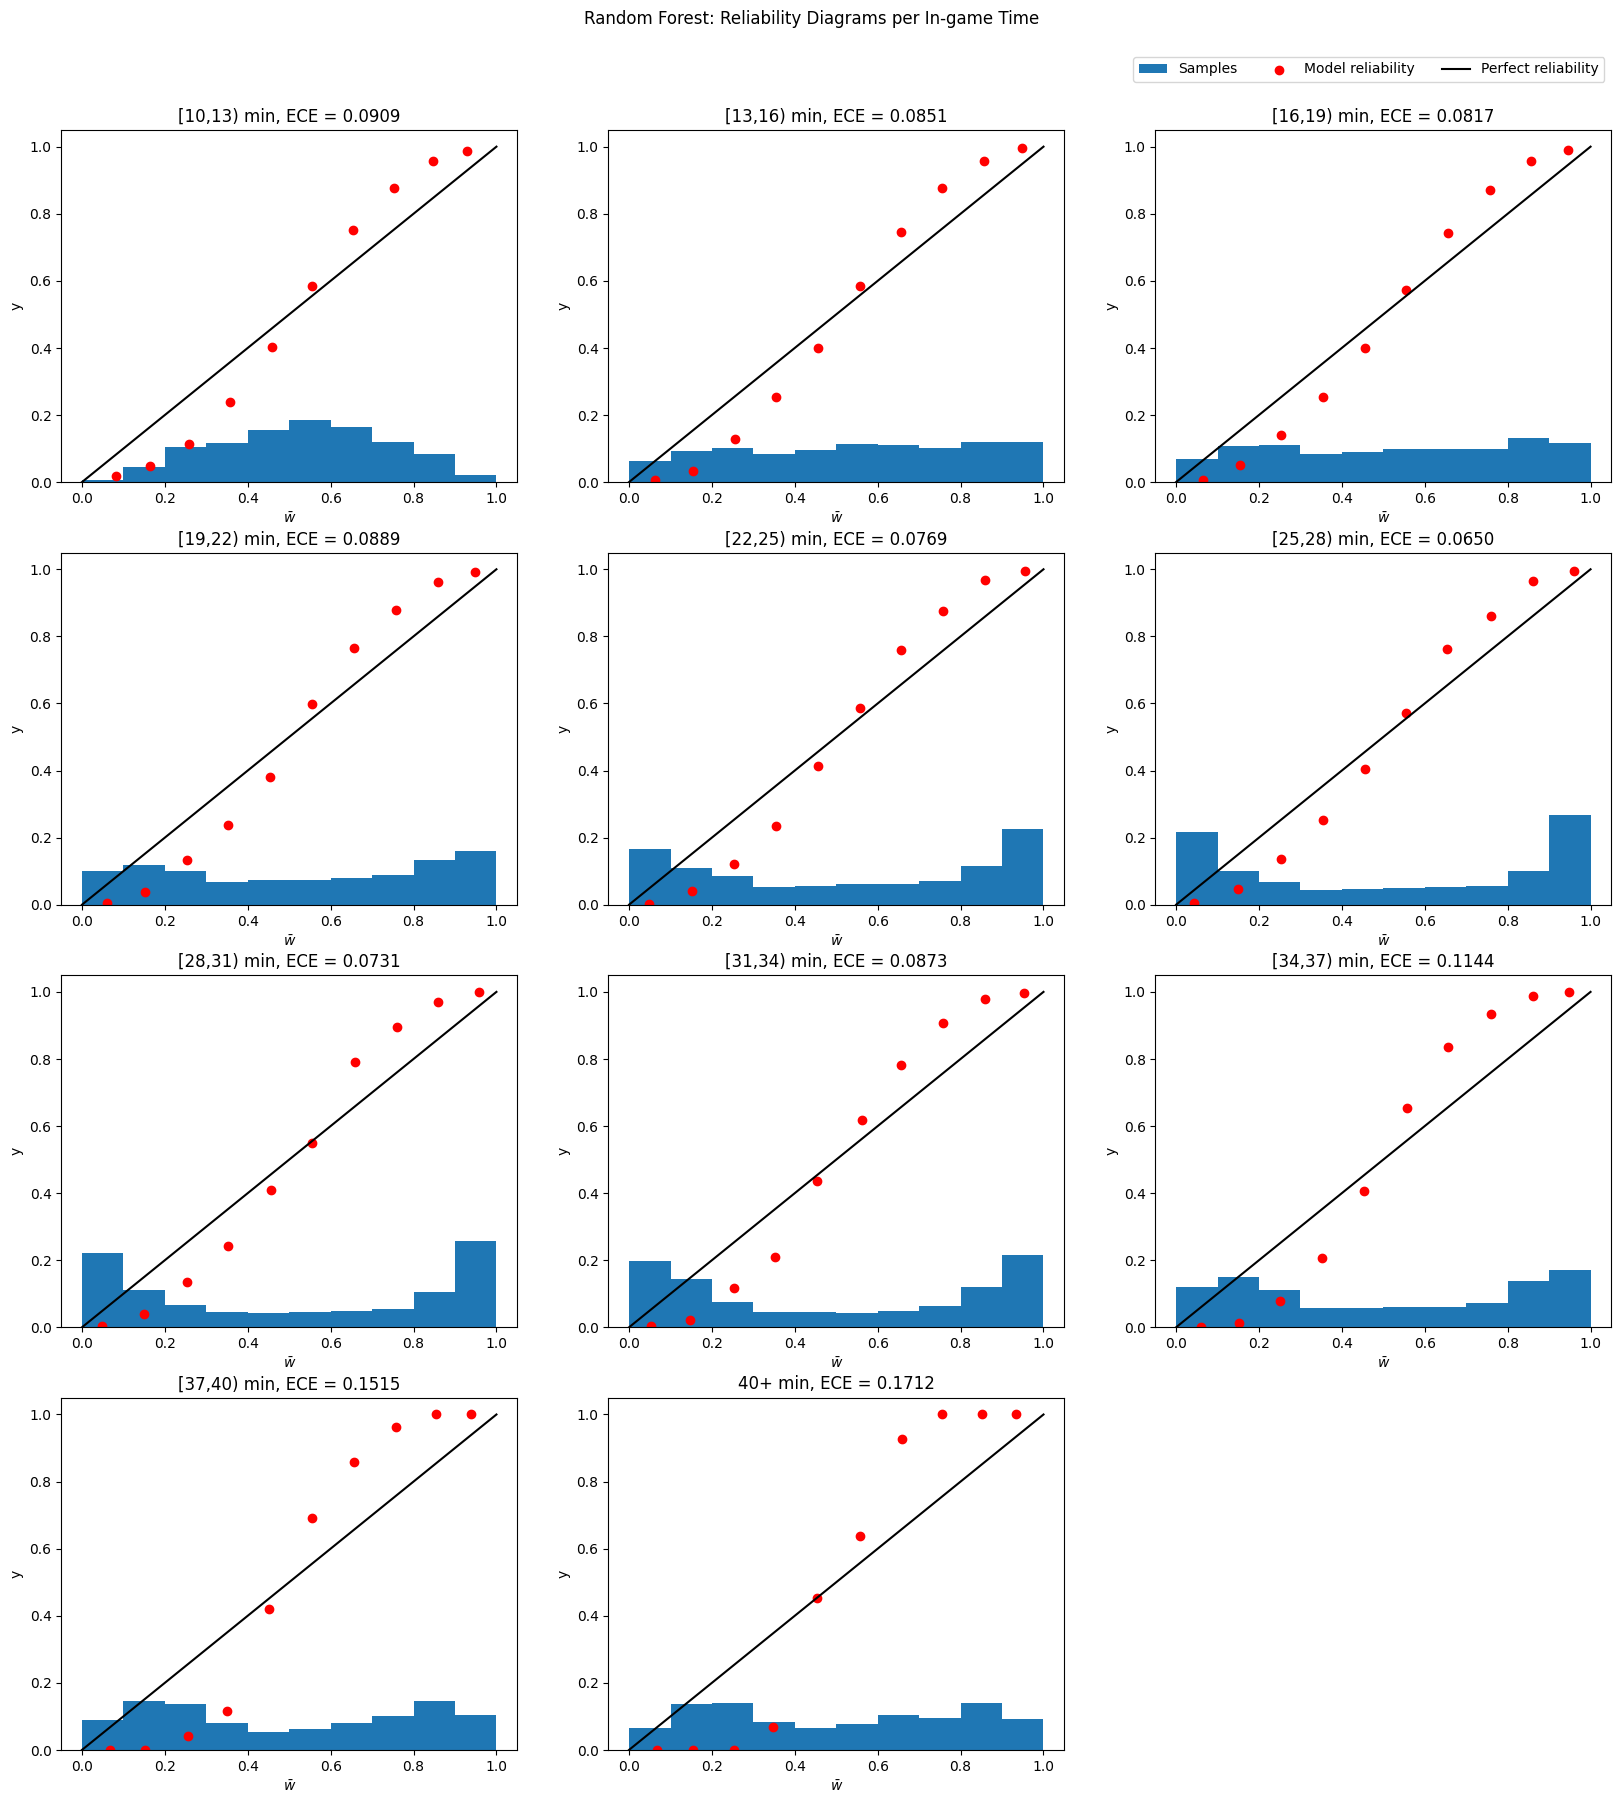

In [47]:
# Create a figure with 12 subplots
fig, ax = plt.subplots(4,3)

#Set appropriate size for figure
fig.set_size_inches(20, 20)


# ax panel indices
i,j = 0,0

for time_interval in game_stages:
    y_true = game_stages[time_interval]['winning_team']
    RF_prob = RF_y_prob[game_stages[time_interval].index,1]
    
    prob_true, prob_pred = calibration_curve(y_true,RF_prob,n_bins = 10)
    ECE_score = ECE_compute(RF_prob,prob_pred,prob_true)

    count,bins = np.histogram(RF_prob,range=[0,1],bins=10)
    ax[i,j].hist(bins[:-1], bins, weights=count/np.sum(count),label='Samples')
    
    ax[i,j].scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
    ax[i,j].plot(x,y,color='black', label = 'Perfect reliability')
    ax[i,j].set_title(f'{time_interval} min, ECE = {ECE_score:.4f}')
    ax[i,j].set_xlabel(r'$\bar{w}$')
    ax[i,j].set_ylabel(r'y')
    
    if j < 2: 
        j += 1
    else:
        i += 1
        j = 0

lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=3,bbox_to_anchor=(0.90, 0.96))
fig.delaxes(ax[3,2])
fig.suptitle('Random Forest: Reliability Diagrams per In-game Time')
fig.subplots_adjust(top=0.92)
plt.savefig('RF_reliability')
plt.show()


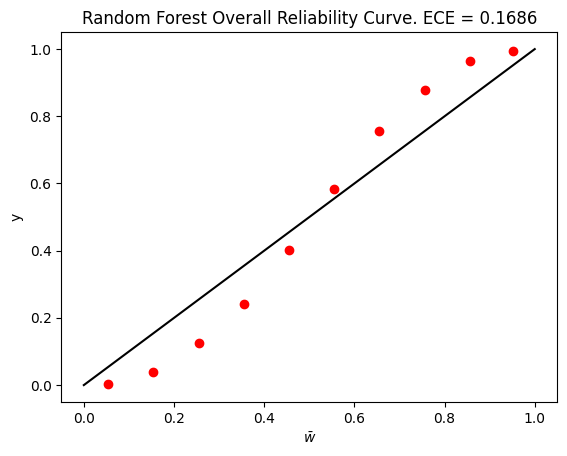

In [55]:
prob_true, prob_pred = calibration_curve(Y,RF_y_prob[:,1],n_bins = 10)
RF_overall_ECE = ECE_compute(RF_y_prob,prob_true,prob_pred)

plt.scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
plt.plot(x,y,color='black', label = 'Perfect reliability')
plt.title(f'Random Forest Overall Reliability Curve. ECE = {RF_overall_ECE:.4f}')
plt.xlabel(r'$\bar{w}$')
plt.ylabel(r'y')
plt.show()

#### Support Vector Machine

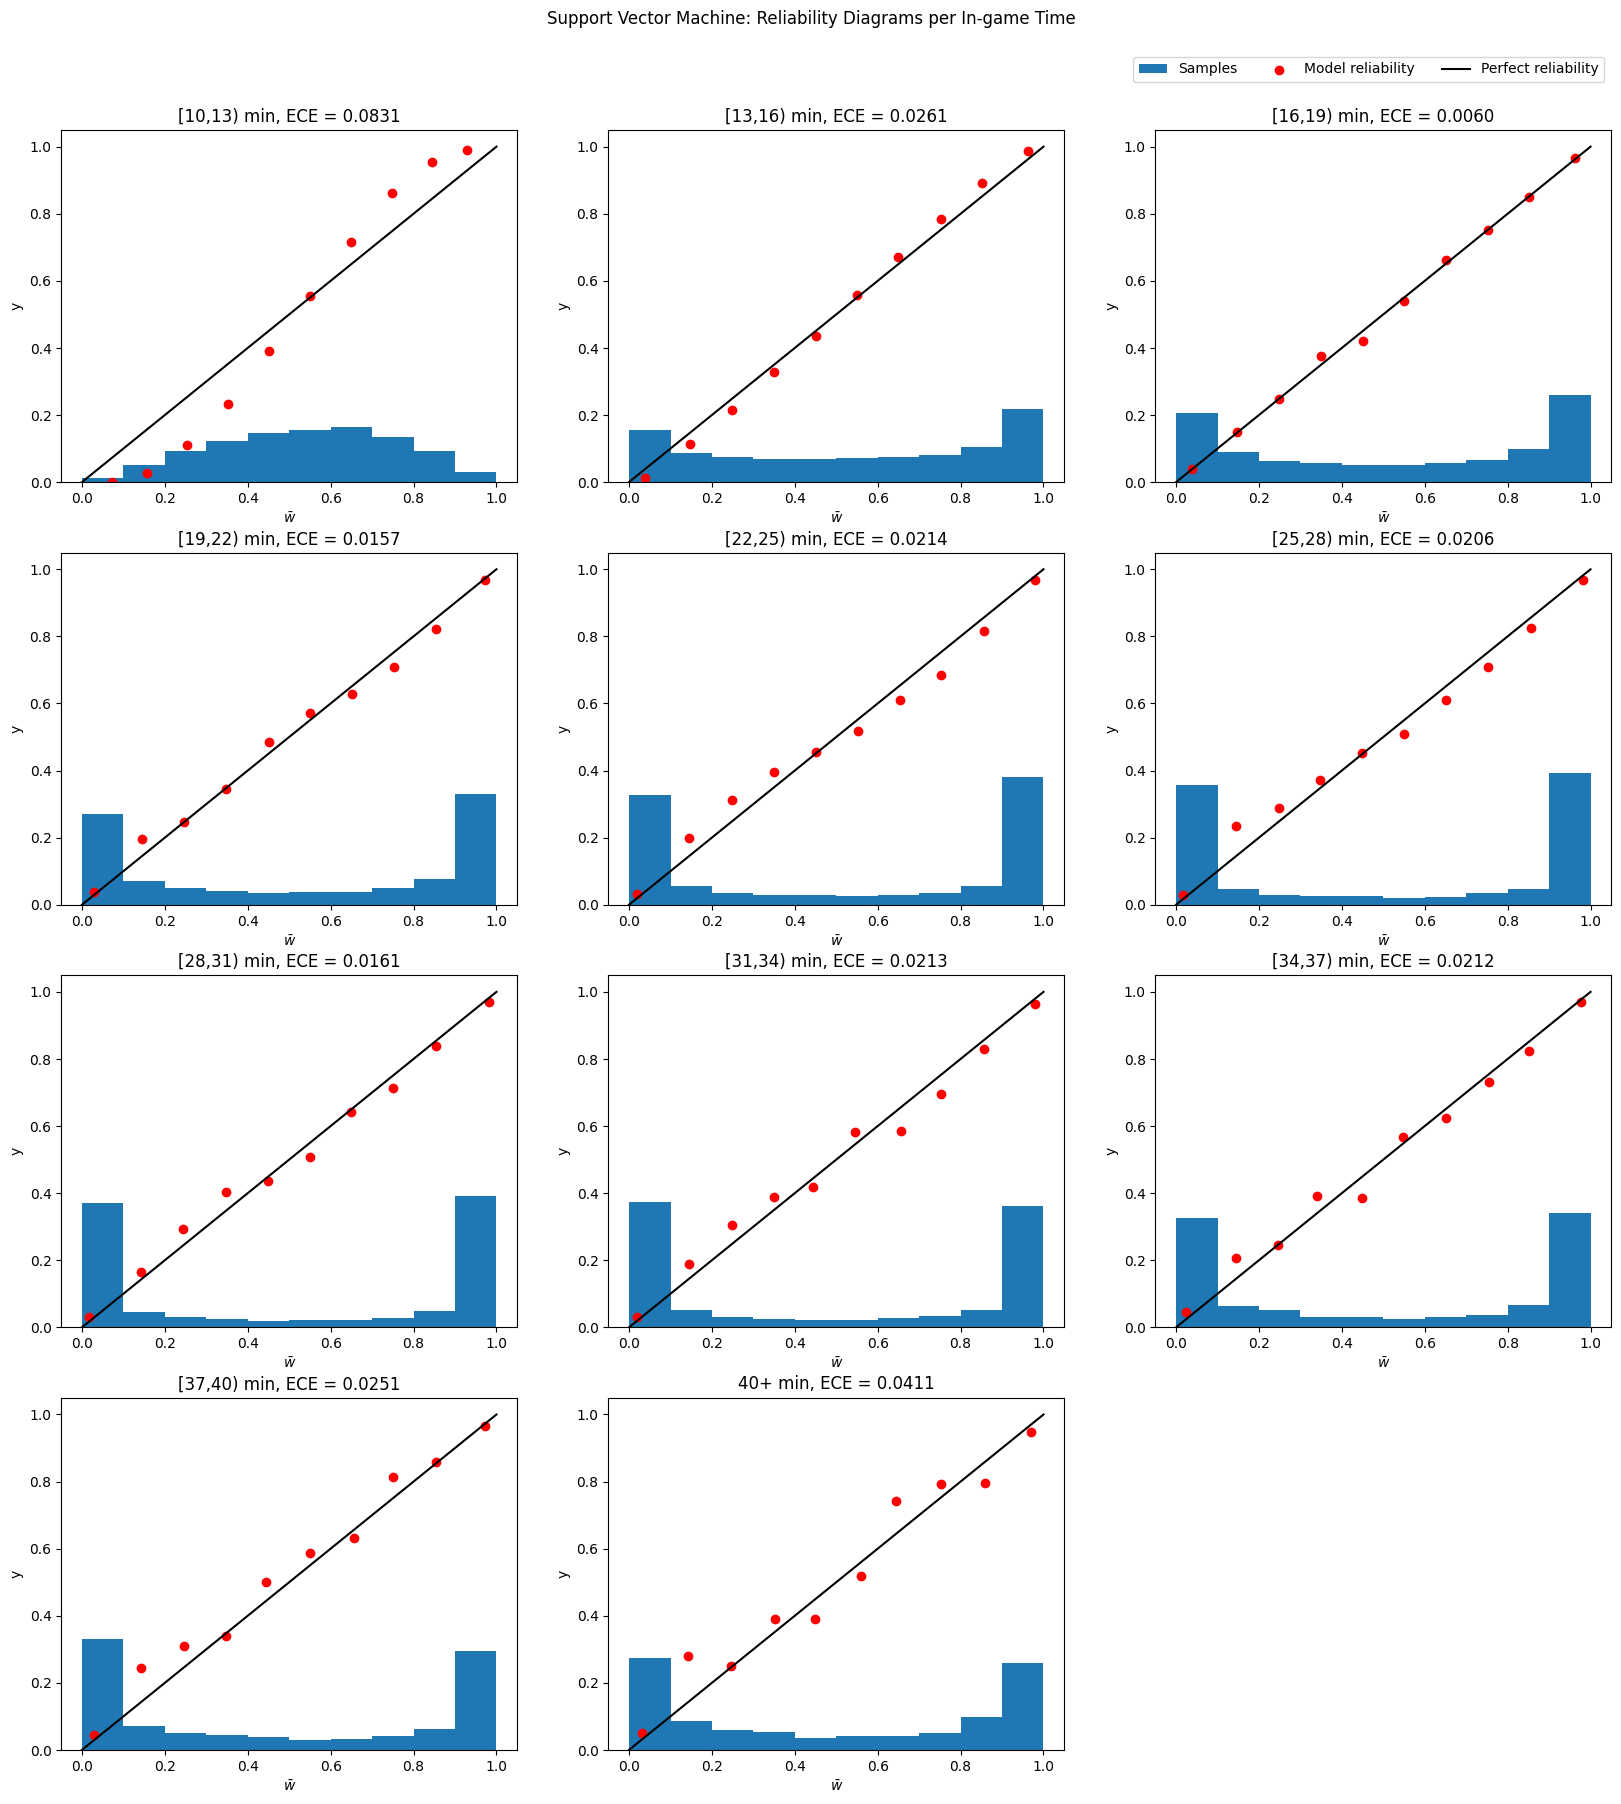

In [56]:
# Create a figure with 12 subplots
fig, ax = plt.subplots(4,3)

#Set appropriate size for figure
fig.set_size_inches(20, 20)


# ax panel indices
i,j = 0,0

for time_interval in game_stages:
    y_true = game_stages[time_interval]['winning_team']
    SVC_prob = SVC_y_prob[game_stages[time_interval].index,1]
    
    prob_true, prob_pred = calibration_curve(y_true,SVC_prob,n_bins = 10)
    ECE_score = ECE_compute(SVC_prob,prob_pred,prob_true)

    count,bins = np.histogram(SVC_prob,range=[0,1],bins=10)
    ax[i,j].hist(bins[:-1], bins, weights=count/np.sum(count),label='Samples')
    
    ax[i,j].scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
    ax[i,j].plot(x,y,color='black', label = 'Perfect reliability')
    ax[i,j].set_title(f'{time_interval} min, ECE = {ECE_score:.4f}')
    ax[i,j].set_xlabel(r'$\bar{w}$')
    ax[i,j].set_ylabel(r'y')
    
    if j < 2: 
        j += 1
    else:
        i += 1
        j = 0

lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=3,bbox_to_anchor=(0.90, 0.96))
fig.delaxes(ax[3,2])
fig.suptitle('Support Vector Machine: Reliability Diagrams per In-game Time')
fig.subplots_adjust(top=0.92)
plt.savefig('SVM_reliability')
plt.show()


In [57]:
prob_true, prob_pred = calibration_curve(Y,SVC_y_prob[:,1],n_bins = 10)
SVC_overall_ECE = ECE_compute(SVC_y_prob,prob_true,prob_pred)
print(f'The ECE score of SVC is {SVC_overall_ECE:.4f}')

The ECE score of SVC is 0.0246


### TRY CALIBRATEDCLASSIFIERCV ON RANDOM FOREST

In [58]:
calibrated_RF = CalibratedClassifierCV(RandomForestClassifier(), cv = k_folds, n_jobs = -1)
calibrated_RF.fit(X,Y)

CalibratedClassifierCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                       estimator=RandomForestClassifier(), n_jobs=-1)

In [ ]:
calibrated_RF_y_pred = calibrated_RF.predict(X)
calibrated_RF_y_prob = calibrated_RF.predict_proba(X)

In [ ]:
calibrated_RF_accuracy = accuracy_score(Y,calibrated_RF_y_pred)
print(calibrated_RF_accuracy)
calibrated_RF_cfm = confusion_matrix(Y,calibrated_RF_y_pred)
ConfusionMatrixDisplay.from_predictions(Y, calibrated_RF_y_pred,display_labels = ['Lost','Win'])

In [ ]:
# Create a figure with 12 subplots
fig, ax = plt.subplots(4,3)

#Set appropriate size for figure
fig.set_size_inches(20, 20)


# ax panel indices
i,j = 0,0

for time_interval in game_stages:
    y_true = game_stages[time_interval]['winning_team']
    calibrated_RF_prob = calibrated_RF_y_prob[game_stages[time_interval].index,1]

        
    prob_true, prob_pred = calibration_curve(y_true,calibrated_RF_prob,n_bins = 10) 
    
    ECE_score = ECE_compute(calibrated_RF_prob,prob_pred,prob_true, num_bins = len(prob_true)) 

    count,bins = np.histogram(calibrated_RF_prob,range=[0,1],bins=len(prob_true))
    ax[i,j].hist(bins[:-1], bins, weights=count/np.sum(count),label='Samples')
    
    ax[i,j].scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
    ax[i,j].plot(x,y,color='black', label = 'Perfect reliability')
    ax[i,j].set_title(f'{time_interval} min, ECE = {ECE_score:.4f}')
    ax[i,j].set_xlabel(r'$\bar{w}$')
    ax[i,j].set_ylabel(r'y')
    
    if j < 2: 
        j += 1
    else:
        i += 1
        j = 0

lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=3,bbox_to_anchor=(0.38, 0.92))
fig.delaxes(ax[3,2])
plt.show()


In [ ]:
prob_true, prob_pred = calibration_curve(Y,calibrated_RF_y_prob[:,1],n_bins = 10)
calibrated_RF_overall_ECE = ECE_compute(calibrated_RF_y_prob,prob_true,prob_pred)

plt.scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
plt.plot(x,y,color='black', label = 'Perfect reliability')
plt.title(f'Calibrated Random Forest Overall Reliability Curve. ECE = {calibrated_RF_overall_ECE:.4f}')
plt.xlabel(r'$\bar{w}$')
plt.ylabel(r'y')
plt.show()